# Data overview of March 2021

In [16]:
import pandas as pd
import os
import json
from datetime import timedelta
import numpy as np

In [17]:
def load_json_bad_format(path):
    parsed_data = []
    with open(path) as f:
        data = f.read() #data is a full string containing all elements separated by new lines
        for line in data.split("\n"): #we split the string by new lines
            try:
                data_point = json.loads(line) #we load each element as a json to transform the string into a dict object
                parsed_data.append(data_point) #we save it into a list
            except:
                print(line)
    return parsed_data

def add_time_data(df, time_column, extra_col_name = ""):
    """transforms time column into datetime format and adds day, month, year, and hour columns.
    In case there is more than one time column in the dataframe you can extend the name of the
    new variables by using the extra_col_name variable"""
    df[time_column] = pd.to_datetime(df[time_column])
    df[extra_col_name + "day"] = df.apply(lambda row: row[time_column].day, axis = 1)
    df[extra_col_name + "month"] = df.apply(lambda row: row[time_column].month, axis = 1)
    df[extra_col_name + "year"] = df.apply(lambda row: row[time_column].year, axis = 1)
    df[extra_col_name + "hour"] = df.apply(lambda row: row[time_column].hour, axis = 1)

    return df


## Loading stations data

In [18]:
data_basepath = "../storage/raw"
path_st = os.path.join(data_basepath, "202105_stations.json")
path_mt = os.path.join(data_basepath, "202105_movements.json")

PROBLEM!! The stations json is not correctly formatted. The format should be:

```
[{item1}, {item2},...]
```

And it is:

{item1} <br>
{item2} <br>
...

We need to parse it. I think movements has the same problem.

In [19]:
st_parsed_data = load_json_bad_format(path_st)

The length of the data extracted makes sense, as march has 31 days. This equals to 744 hours (the data has a row per each hour of the day). As the data recording starts at 00:23, its going to have 1 data point less than expected. I dont understand why he have a 2nd missing data point, but as it is 1/742, i don't think this will have an effect.

In [20]:
len(st_parsed_data)

742

In [21]:
24*31

744

In [22]:
st_parsed_data[0]["_id"]

'2021-05-01T00:23:14.845494'

In [23]:
st_parsed_data[-1]["_id"]

'2021-05-31T23:43:38.926306'

In [24]:
st_parsed_data[0:10]

[{'_id': '2021-05-01T00:23:14.845494',
  'stations': [{'activate': 1,
    'name': 'Puerta del Sol A',
    'reservations_count': 0,
    'light': 2,
    'total_bases': 30,
    'free_bases': 13,
    'number': '1a',
    'longitude': '-3.7018341',
    'no_available': 0,
    'address': 'Puerta del Sol nº 1',
    'latitude': '40.4172137',
    'dock_bikes': 14,
    'id': 1},
   {'activate': 1,
    'name': 'Puerta del Sol B',
    'reservations_count': 0,
    'light': 1,
    'total_bases': 30,
    'free_bases': 5,
    'number': '1b',
    'longitude': '-3.701602938060457',
    'no_available': 0,
    'address': 'Puerta del Sol nº 1',
    'latitude': '40.41731271011562',
    'dock_bikes': 24,
    'id': 2},
   {'activate': 1,
    'name': 'Miguel Moya',
    'reservations_count': 0,
    'light': 0,
    'total_bases': 24,
    'free_bases': 17,
    'number': '2',
    'longitude': '-3.7058415',
    'no_available': 0,
    'address': 'Calle Miguel Moya nº 1',
    'latitude': '40.4205886',
    'dock_bikes':

In [25]:
st_df_sample = pd.DataFrame(st_parsed_data)
st_df_sample

,_id,stations
0,2021-05-01T00:23:14.845494,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
1,2021-05-01T01:23:20.563888,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
2,2021-05-01T02:23:20.606340,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
3,2021-05-01T03:23:21.653407,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
4,2021-05-01T04:23:21.823719,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
...,...,...
737,2021-05-31T19:43:31.651345,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
738,2021-05-31T20:43:32.790392,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
739,2021-05-31T21:43:35.112465,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
740,2021-05-31T22:43:37.163988,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."


Here there are 2 missing hours, as we should have 744 rows. We will create new rows with the same information of stations, BUT with the dock bikes column filled with NaN. We will do this only with hours, as they are easy to input if we have also the plug and unplug data. If we find this problem with days, we should develop another strategy for imputing.

In [26]:
# create a datetime index from the year, month, day, and hour columns
st_df_sample["_id"] = pd.to_datetime(pd.to_datetime(st_df_sample["_id"]))

#we set all the hours to floor. So for example, 00:23:00 will be 00:00:00
#if we don't do this, the method to detect new rows will not work, because
#the resample method will change all indices to 01:00:00 like time indices
# and all indices of the resampled_df will be different from st_df_sample
st_df_sample["_id"] = st_df_sample["_id"].dt.floor("H")
st_df_sample

,_id,stations
0,2021-05-01 00:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
1,2021-05-01 01:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
2,2021-05-01 02:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
3,2021-05-01 03:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
4,2021-05-01 04:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
...,...,...
737,2021-05-31 19:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
738,2021-05-31 20:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
739,2021-05-31 21:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."
740,2021-05-31 22:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '..."


In [27]:
# Assuming that the DataFrame is named st_df_sample
st_df_sample['is_new'] = False  # Initialize the new column to False

# Set the "_id" column as the index of the DataFrame and resample at hourly intervals
resampled_df = st_df_sample.set_index("_id").resample('H').ffill()

# Find the indices of the new rows by comparing the index of the resampled DataFrame
# with the index of the original DataFrame shifted by one hour
new_indices = resampled_df.index.difference(st_df_sample.set_index("_id").index)

# Set the "is_new" column to True for the new rows
resampled_df.loc[new_indices, 'is_new'] = True

resampled_df.reset_index(inplace=True)
resampled_df

,_id,stations,is_new
0,2021-05-01 00:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
1,2021-05-01 01:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
2,2021-05-01 02:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
3,2021-05-01 03:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
4,2021-05-01 04:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
...,...,...,...
739,2021-05-31 19:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
740,2021-05-31 20:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
741,2021-05-31 21:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
742,2021-05-31 22:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False


In [28]:
# Assuming that the DataFrame is named st_df_sample
st_df_sample['is_new'] = False  # Initialize the new column to False

# Set the "_id" column as the index of the DataFrame and resample at hourly intervals
resampled_df = st_df_sample.set_index("_id").resample('H').ffill()

# Find the indices of the new rows by comparing the index of the resampled DataFrame
# with the index of the original DataFrame shifted by one hour
new_indices = resampled_df.index.difference(st_df_sample.set_index("_id").index)

# Set the "is_new" column to True for the new rows
resampled_df.loc[new_indices, 'is_new'] = True

resampled_df.reset_index(inplace=True)
resampled_df

,_id,stations,is_new
0,2021-05-01 00:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
1,2021-05-01 01:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
2,2021-05-01 02:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
3,2021-05-01 03:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
4,2021-05-01 04:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
...,...,...,...
739,2021-05-31 19:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
740,2021-05-31 20:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
741,2021-05-31 21:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False
742,2021-05-31 22:00:00,"[{'activate': 1, 'name': 'Puerta del Sol A', '...",False


We need to uncompress the data. We want a row per station.

In [29]:
st_df_sample = resampled_df.explode("stations").reset_index() #this turns each list into rows with the same 
time = st_df_sample["_id"]
is_new = st_df_sample["is_new"]
st_df_sample = pd.DataFrame(list(st_df_sample["stations"]))

st_df_sample["time"] = time
st_df_sample.loc[is_new,"dock_bikes"] = np.NaN
st_df_sample.loc[is_new,"free_bases"] = np.NaN
st_df_sample.loc[is_new,"reservations_count"] = np.NaN
st_df_sample.rename(columns={"id":"id_station"},inplace=True)

st_df_sample.head()

,activate,name,reservations_count,light,total_bases,free_bases,number,longitude,no_available,address,latitude,dock_bikes,id_station,time
0,1,Puerta del Sol A,0.0,2,30,13.0,1a,-3.7018341,0,Puerta del Sol nº 1,40.4172137,14.0,1,2021-05-01
1,1,Puerta del Sol B,0.0,1,30,5.0,1b,-3.701602938060457,0,Puerta del Sol nº 1,40.41731271011562,24.0,2,2021-05-01
2,1,Miguel Moya,0.0,0,24,17.0,2,-3.7058415,0,Calle Miguel Moya nº 1,40.4205886,5.0,3,2021-05-01
3,1,Plaza Conde Suchil,0.0,2,18,6.0,3,-3.7069171,0,Plaza del Conde del Valle de Súchil nº 3,40.4302937,11.0,4,2021-05-01
4,1,Malasaña,0.0,2,24,10.0,4,-3.7025875,0,Calle Manuela Malasaña nº 5,40.4285524,12.0,5,2021-05-01


In [30]:
st_df_sample.number.unique()

array(['1a', '1b', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20a', '22', '23',
       '24', '25a', '25b', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '65', '67', '68',
       '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79',
       '80a', '80b', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106a', '106b', '107', '108',
       '109', '110', '111a', '111b', '112', '113', '114', '115', '116a',
       '116b', '117', '118', '119', '120', '121', '122', '123', '124',
       '125', '126', '127', '128', '129', '130', '131', '132', '133',
       '134', '135', '136', '137', '138', '139', '140

In [679]:
st_df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196416 entries, 0 to 196415
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   activate            196416 non-null  int64         
 1   name                196416 non-null  object        
 2   reservations_count  196416 non-null  int64         
 3   light               196416 non-null  int64         
 4   total_bases         196416 non-null  int64         
 5   free_bases          195888 non-null  float64       
 6   number              196416 non-null  object        
 7   longitude           196416 non-null  object        
 8   no_available        196416 non-null  int64         
 9   address             196416 non-null  object        
 10  latitude            196416 non-null  object        
 11  dock_bikes          195888 non-null  float64       
 12  id_station          196416 non-null  int64         
 13  time                196416 no

In [567]:
# checking if there is some strange way of writing NaN values. In the trips tables for zip codes blank cells where NaN
st_df_sample[st_df_sample == ""].sum()

/var/folders/yw/h9ndkfbx6_lb6gwchxbgts2m0000gn/T/ipykernel_8219/3494258090.py:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  st_df_sample[st_df_sample == ""].sum()


activate              0.0
name                    0
reservations_count    0.0
light                 0.0
total_bases           0.0
free_bases            0.0
number                  0
longitude               0
no_available          0.0
address                 0
latitude                0
dock_bikes            0.0
id_station            0.0
dtype: object

In [568]:
st_df_sample = add_time_data(st_df_sample, "time")
st_df_sample

,activate,name,reservations_count,light,total_bases,free_bases,number,longitude,no_available,address,latitude,dock_bikes,id_station,time,day,month,year,hour
0,1,Puerta del Sol A,0,2,30,13.0,1a,-3.7018341,0,Puerta del Sol nº 1,40.4172137,14.0,1,2021-05-01 00:00:00,1,5,2021,0
1,1,Puerta del Sol B,0,1,30,5.0,1b,-3.701602938060457,0,Puerta del Sol nº 1,40.41731271011562,24.0,2,2021-05-01 00:00:00,1,5,2021,0
2,1,Miguel Moya,0,0,24,17.0,2,-3.7058415,0,Calle Miguel Moya nº 1,40.4205886,5.0,3,2021-05-01 00:00:00,1,5,2021,0
3,1,Plaza Conde Suchil,0,2,18,6.0,3,-3.7069171,0,Plaza del Conde del Valle de Súchil nº 3,40.4302937,11.0,4,2021-05-01 00:00:00,1,5,2021,0
4,1,Malasaña,0,2,24,10.0,4,-3.7025875,0,Calle Manuela Malasaña nº 5,40.4285524,12.0,5,2021-05-01 00:00:00,1,5,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196411,1,INEF,0,2,24,7.0,257,-3.72997,0,Avenida Juan de Herrera frente a la calle Paul...,40.43896,13.0,265,2021-05-31 23:00:00,31,5,2021,23
196412,1,Ciudad Universitaria 1,0,0,24,23.0,258,-3.72699,0,Avenida de la Complutense (Metro Ciudad Univer...,40.44375,0.0,266,2021-05-31 23:00:00,31,5,2021,23
196413,1,Ciudad Universitaria 2,0,0,24,21.0,259,-3.72693,0,Avenida de la Complutense (Metro Ciudad Univer...,40.44342,1.0,267,2021-05-31 23:00:00,31,5,2021,23
196414,1,Facultad Biología,0,0,24,20.0,260,-3.72731,0,Calle José Antonio Novais frente al nº 12,40.44912,3.0,268,2021-05-31 23:00:00,31,5,2021,23


Here we check that we have the same number of rows per each day and per each hour to ensure there is nothing missing

In [569]:
st_df_sample.value_counts("day")

day
1     6336
17    6336
30    6336
29    6336
28    6336
27    6336
26    6336
25    6336
24    6336
23    6336
22    6336
21    6336
20    6336
19    6336
18    6336
16    6336
2     6336
15    6336
14    6336
13    6336
12    6336
11    6336
10    6336
9     6336
8     6336
7     6336
6     6336
5     6336
4     6336
3     6336
31    6336
dtype: int64

In [570]:
st_df_sample.value_counts("hour")

hour
0     8184
1     8184
22    8184
21    8184
20    8184
19    8184
18    8184
17    8184
16    8184
15    8184
14    8184
13    8184
12    8184
11    8184
10    8184
9     8184
8     8184
7     8184
6     8184
5     8184
4     8184
3     8184
2     8184
23    8184
dtype: int64

In [571]:
st_df_sample["day"].value_counts()

1     6336
17    6336
30    6336
29    6336
28    6336
27    6336
26    6336
25    6336
24    6336
23    6336
22    6336
21    6336
20    6336
19    6336
18    6336
16    6336
2     6336
15    6336
14    6336
13    6336
12    6336
11    6336
10    6336
9     6336
8     6336
7     6336
6     6336
5     6336
4     6336
3     6336
31    6336
Name: day, dtype: int64

In [572]:
st_df_sample.describe()

,activate,reservations_count,light,total_bases,free_bases,no_available,dock_bikes,id_station,day,month,year,hour
count,196416.0,196416.000000,196416.000000,196416.000000,195888.000000,196416.000000,195888.000000,196416.000000,196416.000000,196416.0,196416.0,196416.000000
mean,1.0,0.077259,1.046641,23.920455,12.394680,0.015854,9.731387,136.829545,16.000000,5.0,2021.0,11.500000
std,0.0,0.302209,0.916607,1.874201,6.507195,0.124911,6.342394,77.329269,8.944295,0.0,0.0,6.922204
min,1.0,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.0,2021.0,0.000000
25%,1.0,0.000000,0.000000,24.000000,7.000000,0.000000,4.000000,71.750000,8.000000,5.0,2021.0,5.750000
50%,1.0,0.000000,1.000000,24.000000,13.000000,0.000000,9.000000,137.500000,16.000000,5.0,2021.0,11.500000
75%,1.0,0.000000,2.000000,24.000000,18.000000,0.000000,14.000000,203.250000,24.000000,5.0,2021.0,17.250000
max,1.0,4.000000,3.000000,30.000000,30.000000,1.000000,30.000000,270.000000,31.000000,5.0,2021.0,23.000000


We keep only the information that is important for each timestamp. The rest of the information can be kept in a describing table of each station that can be merged by id.

In [573]:
st_df_sample = st_df_sample[["activate", "reservations_count","light", "no_available", "dock_bikes","total_bases","free_bases", "id_station","time", "year","month","day","hour"]]
st_df_sample

,activate,reservations_count,light,no_available,dock_bikes,id_station,time,year,month,day,hour
0,1,0,2,0,14.0,1,2021-05-01 00:00:00,2021,5,1,0
1,1,0,1,0,24.0,2,2021-05-01 00:00:00,2021,5,1,0
2,1,0,0,0,5.0,3,2021-05-01 00:00:00,2021,5,1,0
3,1,0,2,0,11.0,4,2021-05-01 00:00:00,2021,5,1,0
4,1,0,2,0,12.0,5,2021-05-01 00:00:00,2021,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...
196411,1,0,2,0,13.0,265,2021-05-31 23:00:00,2021,5,31,23
196412,1,0,0,0,0.0,266,2021-05-31 23:00:00,2021,5,31,23
196413,1,0,0,0,1.0,267,2021-05-31 23:00:00,2021,5,31,23
196414,1,0,0,0,3.0,268,2021-05-31 23:00:00,2021,5,31,23


## Loading trips data

In [574]:
st_parsed_data = load_json_bad_format(path_mt)

In [575]:
mt_df_sample = pd.DataFrame(st_parsed_data)
mt_df_sample["_id"] = mt_df_sample["_id"].apply(lambda id: id["$oid"]) #for some reason the id contained a dictionary which only contained the id
mt_df_sample

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code
0,6093156e1b91311e205ea946,064ab31ac9ea01016a78576f442ad53b6055faf5486e29...,15,1,6,488,15,0,91,2021-05-01T00:00:00Z,
1,6093156e1b91311e205ea947,9ad5e191c50694a8653b5f310a3a5ee769b5e8cf87595e...,23,1,19,754,104,0,86,2021-05-01T00:00:00Z,
2,6093156e1b91311e205ea948,7019de3db24cf1294a743248ebdd8200d9bb351b76a59d...,18,1,22,900,170,0,215,2021-05-01T00:00:00Z,
3,6093156e1b91311e205ea950,d2d6cfb2453cae1091e8f5e6c8a6027388fd2977360eab...,24,1,16,823,134,4,106,2021-05-01T00:00:00Z,28028
4,6093156e1b91311e205ea951,a2b096809571c4ec169373f4e757a682dade32fd02dde1...,20,1,16,283,175,3,177,2021-05-01T00:00:00Z,28005
...,...,...,...,...,...,...,...,...,...,...,...
414244,60c67ff31b913135206cb1f5,97f2122de3336afde872d88307bbba5e381cda87c07ce6...,3,3,2,2032731,2009,5,111,2021-05-16T09:00:00Z,
414245,60c67ff31b913135206cb1fd,97f2122de3336afde872d88307bbba5e381cda87c07ce6...,4,3,2,2032870,2009,5,111,2021-05-16T09:00:00Z,
414246,60c67ff51b913135206cb357,97f2122de3336afde872d88307bbba5e381cda87c07ce6...,27,3,2,1697182,2009,5,101,2021-05-20T08:00:00Z,
414247,60c67ff51b913135206cb3b1,6c05d2f0a268b51e964d8c877a5cb131e0657a9690d6df...,18,3,2,1699064,2009,5,266,2021-05-20T08:00:00Z,


In [576]:
# for zip code, where there isn't a value the space is empty. It should be nan
mt_df_sample = mt_df_sample.replace("",np.NaN)

In [577]:
mt_df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414249 entries, 0 to 414248
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   _id               414249 non-null  object
 1   user_day_code     414249 non-null  object
 2   idplug_base       414249 non-null  int64 
 3   user_type         414249 non-null  int64 
 4   idunplug_base     414249 non-null  int64 
 5   travel_time       414249 non-null  int64 
 6   idunplug_station  414249 non-null  int64 
 7   ageRange          414249 non-null  int64 
 8   idplug_station    414249 non-null  int64 
 9   unplug_hourTime   414249 non-null  object
 10  zip_code          162948 non-null  object
dtypes: int64(7), object(4)
memory usage: 34.8+ MB


We only have NaN for zip code. Good news!

In [578]:
mt_df_sample.describe()

,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station
count,414249.000000,414249.000000,414249.000000,4.142490e+05,414249.000000,414249.000000,414249.000000
mean,12.342333,1.148722,12.327682,1.357215e+03,123.794942,1.887978,123.440255
std,7.568631,0.649777,7.552421,2.557734e+04,83.075475,2.194663,79.912399
min,1.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000
25%,5.000000,1.000000,5.000000,4.900000e+02,56.000000,0.000000,56.000000
50%,12.000000,1.000000,12.000000,7.500000e+02,122.000000,0.000000,122.000000
75%,19.000000,1.000000,19.000000,1.112000e+03,185.000000,4.000000,185.000000
max,30.000000,7.000000,30.000000,2.361287e+06,2009.000000,6.000000,2009.000000


### Adding plug_hourTime and separating both time data into year, month, day, and hour

We are going to use the travel time to calculate the plug time. Careful!!!! Innova talks about the possibility of travel_time being negative. We should build the code robust to that case. Innova inputs that data as the mean. Time is in seconds. Innova inputs to the mean the values smaller than 60 seconds. To set the upper limit we shoud check the time it takes in google maps to travel between the furthest stations of the system and set a % of margin (to take into account events such as stop to rest, talk with somebody, etc.). The maximum travel time between furthest stations (calculated with google maps) is 53 minutes by bike. We will assume this is a good approximation and we will use 1:30 hours as a limit. 


On the other hand, this time_travel values could be indicators of other events such as stolen bikes, lost bikes, or malfunctioning dock stations that don't stop travel time for those users. So for the moment, we will only impute as mean the values < 60 seconds

In [579]:
print("mean travel time of: %.3f minutes"%(mt_df_sample["travel_time"].mean()/60))

mean travel time of: 22.620 minutes


In [580]:
# Here we input the mean for all time_travel values smaller than 60 seconds (which includes negative values too)
mt_df_sample.loc[mt_df_sample["travel_time"]< 60,"travel_time"] = mt_df_sample["travel_time"].mean()

In [581]:
#testing how to add travel time to unplug_hourTime
delta_time = mt_df_sample["travel_time"].apply(lambda row: timedelta(seconds=int(row)))

pd.concat((delta_time,mt_df_sample["unplug_hourTime"],pd.to_datetime(mt_df_sample["unplug_hourTime"]) + delta_time), 
           axis = 1).head()

,travel_time,unplug_hourTime,0
0,0 days 00:08:08,2021-05-01T00:00:00Z,2021-05-01 00:08:08+00:00
1,0 days 00:12:34,2021-05-01T00:00:00Z,2021-05-01 00:12:34+00:00
2,0 days 00:15:00,2021-05-01T00:00:00Z,2021-05-01 00:15:00+00:00
3,0 days 00:13:43,2021-05-01T00:00:00Z,2021-05-01 00:13:43+00:00
4,0 days 00:04:43,2021-05-01T00:00:00Z,2021-05-01 00:04:43+00:00


In [582]:
#creating plug_hourTime
mt_df_sample["travel_time"] = mt_df_sample["travel_time"].apply(lambda row: timedelta(seconds=int(row)))
mt_df_sample["plug_hourTime"] = pd.to_datetime(mt_df_sample["unplug_hourTime"]) + mt_df_sample["travel_time"]

#creating year,month,day and hour columns
mt_df_sample = add_time_data(mt_df_sample, "unplug_hourTime", extra_col_name="unplug_")
mt_df_sample = add_time_data(mt_df_sample, "plug_hourTime", extra_col_name="plug_")
mt_df_sample.head()

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code,plug_hourTime,unplug_day,unplug_month,unplug_year,unplug_hour,plug_day,plug_month,plug_year,plug_hour
0,6093156e1b91311e205ea946,064ab31ac9ea01016a78576f442ad53b6055faf5486e29...,15,1,6,0 days 00:08:08,15,0,91,2021-05-01 00:00:00+00:00,NaN,2021-05-01 00:08:08+00:00,1,5,2021,0,1,5,2021,0
1,6093156e1b91311e205ea947,9ad5e191c50694a8653b5f310a3a5ee769b5e8cf87595e...,23,1,19,0 days 00:12:34,104,0,86,2021-05-01 00:00:00+00:00,NaN,2021-05-01 00:12:34+00:00,1,5,2021,0,1,5,2021,0
2,6093156e1b91311e205ea948,7019de3db24cf1294a743248ebdd8200d9bb351b76a59d...,18,1,22,0 days 00:15:00,170,0,215,2021-05-01 00:00:00+00:00,NaN,2021-05-01 00:15:00+00:00,1,5,2021,0,1,5,2021,0
3,6093156e1b91311e205ea950,d2d6cfb2453cae1091e8f5e6c8a6027388fd2977360eab...,24,1,16,0 days 00:13:43,134,4,106,2021-05-01 00:00:00+00:00,28028,2021-05-01 00:13:43+00:00,1,5,2021,0,1,5,2021,0
4,6093156e1b91311e205ea951,a2b096809571c4ec169373f4e757a682dade32fd02dde1...,20,1,16,0 days 00:04:43,175,3,177,2021-05-01 00:00:00+00:00,28005,2021-05-01 00:04:43+00:00,1,5,2021,0,1,5,2021,0


## Merging the data

Problem!! The ids from stations and movements don't match. Movements is missing 2 ids (123,124) and has an extra id (2009) that looks like some kind of error. Innova solution for the hackathon was to merge only the ids contained in the stations dataset, which ignores the "station" 2009. With respect to the stations missing in movements, this could be provoked by no one using those stations during the whole month (here we are just testing for 1 month).

### Analising ids match for stations and movements

In [583]:
print(len(st_df_sample["id_station"].value_counts().index))
st_ids = np.sort(list(st_df_sample["id_station"].value_counts().index))
print(st_ids)

264
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  69  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 25

In [584]:
print(len(mt_df_sample["idplug_station"].value_counts().index))
mt_ids = np.sort(list(mt_df_sample["idplug_station"].value_counts().index))
print(mt_ids)

263
[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   25   26   27   28   29   30   31
   32   33   34   35   36   37   38   39   40   41   42   43   44   45
   46   47   48   49   50   51   52   53   54   55   56   57   58   59
   60   61   62   63   64   65   66   67   69   71   72   73   74   75
   76   77   78   79   80   81   82   83   84   85   86   87   88   89
   90   91   92   93   94   95   96   97   98   99  100  101  102  103
  104  105  106  107  108  109  110  111  112  113  114  115  116  117
  118  119  120  121  122  125  126  127  128  129  130  131  132  133
  134  135  136  137  138  139  140  141  142  143  144  145  146  147
  148  149  150  151  152  153  154  155  156  157  158  159  160  161
  162  163  164  165  166  167  168  169  170  171  172  173  174  175
  176  177  178  179  180  181  182  183  184  185  186  187  188  189
  190  191  192  193  194  195  196  197  198  199  200  201  202  203
  

In [585]:
set_st = set(st_ids)
set_mt = set(mt_ids)

print(len(set_st))
print(len(set_mt))

print(set_st.difference(set_mt))
print(set_mt.difference(set_st))

264
263
{123, 124}
{2009}


### Preparing movements data (we only want plugs and unplugs counts)

In [586]:
#filtering to only keep stations that exist in stations dataframe
mt_df_sample = mt_df_sample.loc[(mt_df_sample["idplug_station"].isin(set_st)) & (mt_df_sample["idunplug_station"].isin(set_st)),]

In [587]:
plugs_df = mt_df_sample.groupby(["plug_year", "plug_month", "plug_day","plug_hour","idplug_station"]).size().reset_index()
plugs_df.columns = ["year", "month", "day","hour","id_station","plugs_count"]

unplugs_df = mt_df_sample.groupby(["unplug_year", "unplug_month", "unplug_day","unplug_hour","idunplug_station"]).size().reset_index()
unplugs_df.columns = ["year", "month", "day","hour","id_station","unplugs_count"]

#this merge has to be outer. For those moments where there aren't 
# no plugs or unplugs, the NaN will be substituted with 0
plugs_unplugs_df = pd.merge(plugs_df, unplugs_df, on = ["year", "month", "day","hour","id_station"], how = "outer")
plugs_unplugs_df[plugs_unplugs_df.isna()] = 0
plugs_unplugs_df.describe()


,year,month,day,hour,id_station,plugs_count,unplugs_count
count,144135.0,144135.000000,144135.000000,144135.000000,144135.000000,144135.000000,144135.000000
mean,2021.0,5.000035,16.365081,12.876276,133.267194,2.872925,2.872925
std,0.0,0.005890,8.835352,5.818057,76.668056,3.006481,2.955792
min,2021.0,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,2021.0,5.000000,9.000000,8.000000,65.000000,1.000000,1.000000
50%,2021.0,5.000000,17.000000,13.000000,134.000000,2.000000,2.000000
75%,2021.0,5.000000,24.000000,18.000000,199.000000,4.000000,4.000000
max,2021.0,6.000000,31.000000,23.000000,270.000000,39.000000,41.000000


In [588]:
plugs_unplugs_df.head()

,year,month,day,hour,id_station,plugs_count,unplugs_count
0,2021,5,1,0,10,1.0,0.0
1,2021,5,1,0,48,1.0,0.0
2,2021,5,1,0,58,1.0,0.0
3,2021,5,1,0,86,1.0,0.0
4,2021,5,1,0,91,1.0,0.0


### Innova's approach: merge on the stations dataset ids only

In [600]:
st_df_sample

,activate,reservations_count,light,no_available,dock_bikes,id_station,time,year,month,day,hour
0,1,0,2,0,14.0,1,2021-05-01 00:00:00,2021,5,1,0
1,1,0,1,0,24.0,2,2021-05-01 00:00:00,2021,5,1,0
2,1,0,0,0,5.0,3,2021-05-01 00:00:00,2021,5,1,0
3,1,0,2,0,11.0,4,2021-05-01 00:00:00,2021,5,1,0
4,1,0,2,0,12.0,5,2021-05-01 00:00:00,2021,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...
196411,1,0,2,0,13.0,265,2021-05-31 23:00:00,2021,5,31,23
196412,1,0,0,0,0.0,266,2021-05-31 23:00:00,2021,5,31,23
196413,1,0,0,0,1.0,267,2021-05-31 23:00:00,2021,5,31,23
196414,1,0,0,0,3.0,268,2021-05-31 23:00:00,2021,5,31,23


In [617]:
# we have already filtered the movements dataframe to contain only ids existing in stations dataframe
final_df = pd.merge(st_df_sample, 
                    plugs_unplugs_df, 
                    on = ["year", "month", "day","hour","id_station"],
                    how = "outer")
# those rows where plugs and unplugs are NaN are the hours where no trip data is available meaning that the number
# of plugs AND unplugs is 0
final_df.loc[final_df[["plugs_count", "unplugs_count"]].isnull().all(axis=1), ["plugs_count", "unplugs_count"]] = 0

final_df

,activate,reservations_count,light,no_available,dock_bikes,id_station,time,year,month,day,hour,plugs_count,unplugs_count
0,1.0,0.0,2.0,0.0,14.0,1,2021-05-01,2021,5,1,0,0.0,0.0
1,1.0,0.0,1.0,0.0,24.0,2,2021-05-01,2021,5,1,0,0.0,0.0
2,1.0,0.0,0.0,0.0,5.0,3,2021-05-01,2021,5,1,0,0.0,0.0
3,1.0,0.0,2.0,0.0,11.0,4,2021-05-01,2021,5,1,0,0.0,0.0
4,1.0,0.0,2.0,0.0,12.0,5,2021-05-01,2021,5,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196416,NaN,NaN,NaN,NaN,NaN,262,NaT,2021,6,1,0,1.0,0.0
196417,NaN,NaN,NaN,NaN,NaN,217,NaT,2021,6,1,17,1.0,0.0
196418,NaN,NaN,NaN,NaN,NaN,93,NaT,2021,6,1,20,1.0,0.0
196419,NaN,NaN,NaN,NaN,NaN,227,NaT,2021,6,3,10,1.0,0.0


In [663]:
final_df.loc[(final_df["day"] == 14) & (final_df["hour"]>7) & (final_df["hour"]<22),]

,activate,reservations_count,light,no_available,dock_bikes,id_station,time,year,month,day,hour,plugs_count,unplugs_count
84480,1.0,0.0,0.0,0.0,1.0,1,2021-05-14 08:00:00,2021,5,14,8,3.0,0.0
84481,1.0,0.0,0.0,0.0,4.0,2,2021-05-14 08:00:00,2021,5,14,8,0.0,0.0
84482,1.0,0.0,2.0,0.0,13.0,3,2021-05-14 08:00:00,2021,5,14,8,2.0,1.0
84483,1.0,1.0,2.0,0.0,8.0,4,2021-05-14 08:00:00,2021,5,14,8,3.0,1.0
84484,1.0,0.0,1.0,0.0,16.0,5,2021-05-14 08:00:00,2021,5,14,8,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88171,1.0,0.0,2.0,0.0,7.0,265,2021-05-14 21:00:00,2021,5,14,21,2.0,0.0
88172,1.0,0.0,3.0,1.0,5.0,266,2021-05-14 21:00:00,2021,5,14,21,0.0,0.0
88173,1.0,0.0,0.0,0.0,6.0,267,2021-05-14 21:00:00,2021,5,14,21,0.0,1.0
88174,1.0,0.0,2.0,0.0,8.0,268,2021-05-14 21:00:00,2021,5,14,21,0.0,0.0


In [619]:
#this data points that are not correctly merged happen because they are moved to the next month. 
# When we automate the download/preparation process we will need to take this into account
final_df.loc[final_df["activate"].isna(), ["year", "month", "day", "hour"]]

,year,month,day,hour
196416,2021,6,1,0
196417,2021,6,1,17
196418,2021,6,1,20
196419,2021,6,3,10
196420,2021,6,7,18


## Problems
+ we have some extreme data in time travel (100s of hours) --> maybe lost bikes/ errors of docking ports/ stolen bikes
+ station data is missing 2 hours of 1 day. Is this a general thing? Maybe we need a robust solution. Approaches;
    - just interpolate between previous/post hours
    - use trips data to deduct the quantity of bikes at that moment


## Visualization

In [652]:
import seaborn as sns

final_df = final_df[final_df["month"] == 5]
unplugs_data_month = final_df[["day","unplugs_count", "plugs_count"]].groupby("day").sum().reset_index()

<AxesSubplot:xlabel='day', ylabel='plugs_count'>

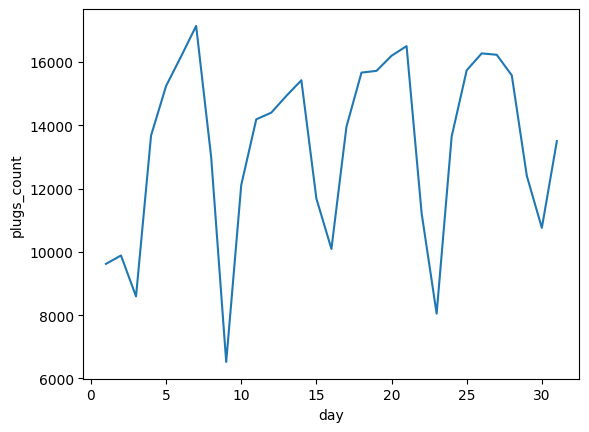

In [653]:
sns.lineplot(x="day", y="plugs_count",
             data=unplugs_data_month)

<AxesSubplot:xlabel='day', ylabel='unplugs_count'>

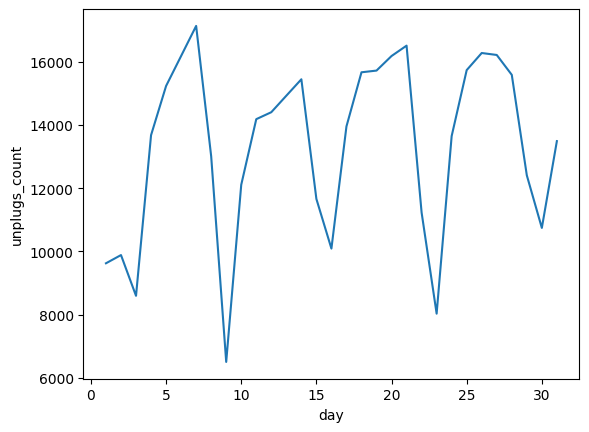

In [656]:
sns.lineplot(x="day", y="unplugs_count",
             data=unplugs_data_month)

<AxesSubplot:xlabel='day', ylabel='value'>

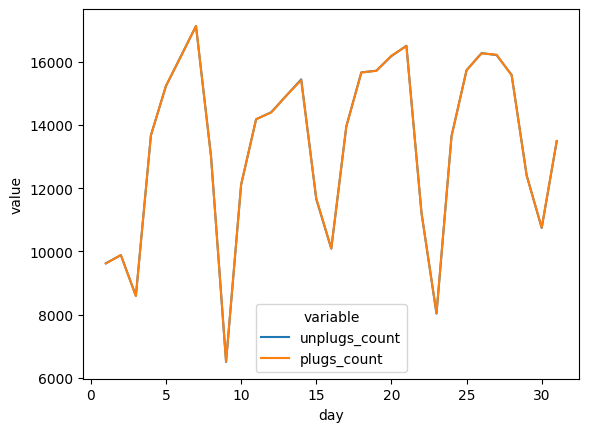

In [655]:
sns.lineplot(x="day", y="value", hue = "variable",
             data=pd.melt(unplugs_data_month, ['day']))

<AxesSubplot:xlabel='day', ylabel='unplugs_count'>

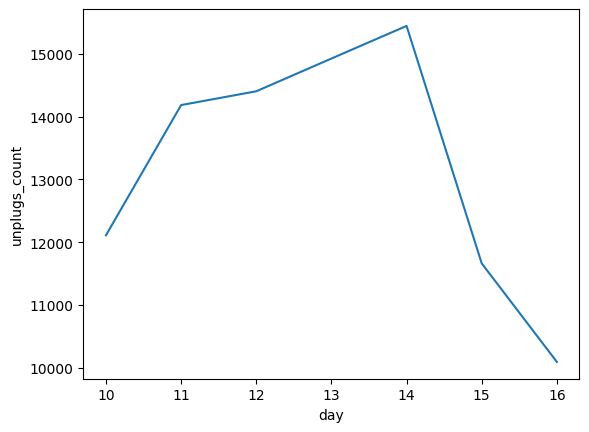

In [658]:
unplugs_data_week = final_df.loc[(final_df["day"] > 9) & (final_df["day"]<17),["day","unplugs_count", "plugs_count"]].groupby("day").sum().reset_index()

sns.lineplot(x="day", y="unplugs_count",
             data=unplugs_data_week)

<AxesSubplot:xlabel='day', ylabel='plugs_count'>

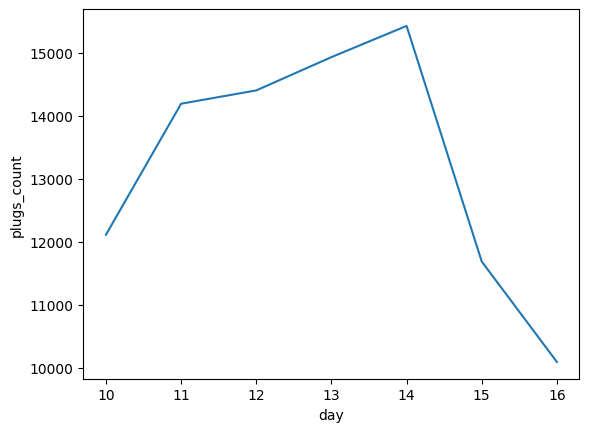

In [659]:
sns.lineplot(x="day", y="plugs_count",
             data=unplugs_data_week)

<AxesSubplot:xlabel='day', ylabel='value'>

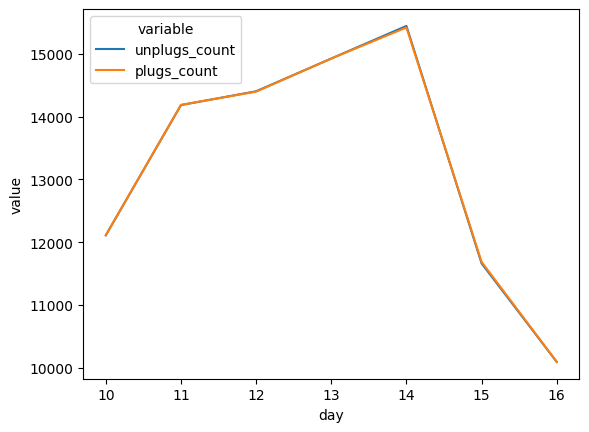

In [660]:
sns.lineplot(x="day", y="value", hue = "variable",
             data=pd.melt(unplugs_data_week, ['day']))